### Event Driven AI Agents

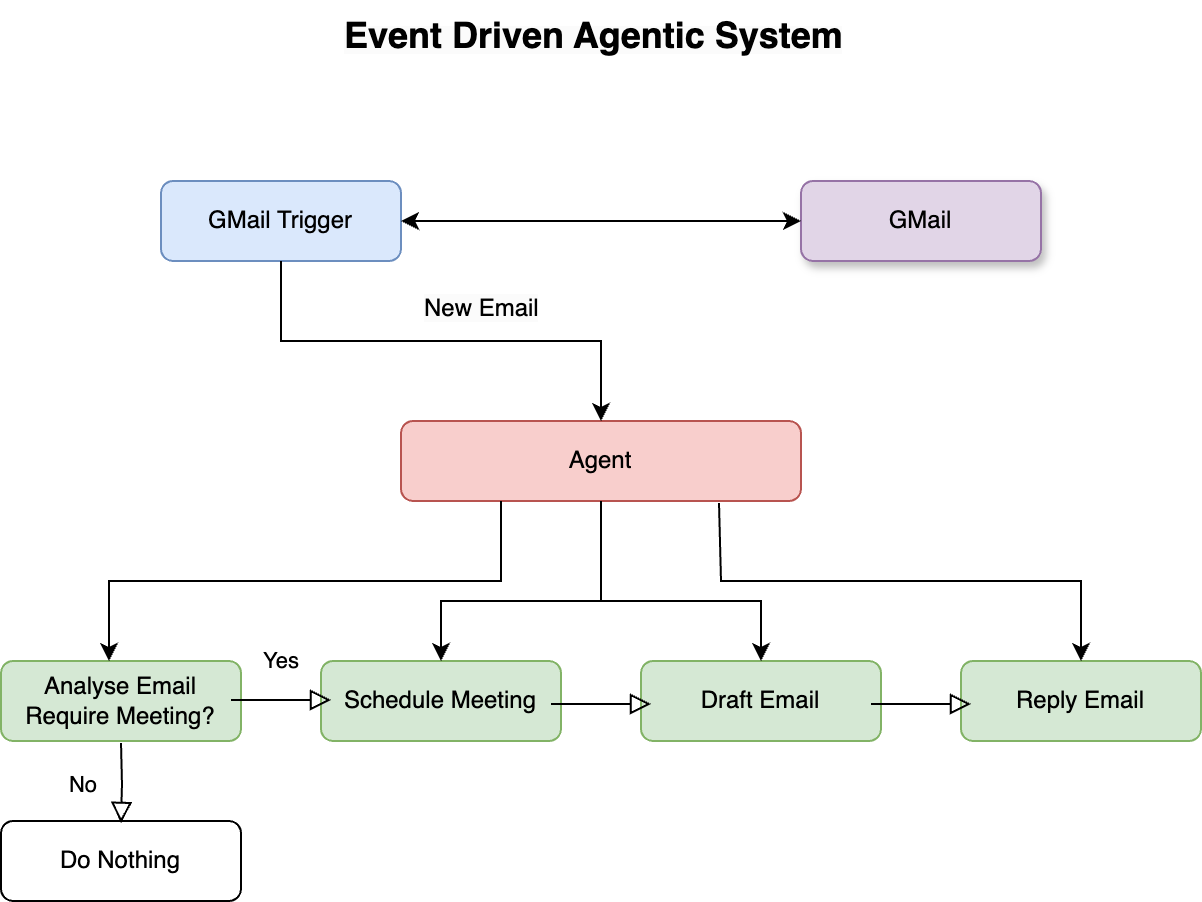

In [2]:
from IPython.display import Image
img="/Users/sridharkannam/Downloads/event_agents.drawio.png"
Image(img)

In [ ]:
import os
import re
from datetime import datetime
from composio.client.collections import TriggerEventData
from composio_crewai import Action, ComposioToolSet
from crewai import Agent, Crew, Task, Process
from langchain_openai import ChatOpenAI

In [ ]:
composio_toolset = ComposioToolSet()

calender_tools = composio_toolset.get_tools(
    actions=[
        Action.GOOGLECALENDAR_FIND_FREE_SLOTS,
        Action.GOOGLECALENDAR_CREATE_EVENT,
    ]
)


#email_tool = composio_toolset.get_tools(actions=[Action.GMAIL_CREATE_EMAIL_DRAFT])
email_tools = composio_toolset.get_tools(actions=[Action.GMAIL_SEND_EMAIL])

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
listener = composio_toolset.create_trigger_listener()

In [ ]:
date_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
timezone = datetime.now().astimezone().tzinfo

In [ ]:
email_assistant = Agent(
    role="Email/Calendar Assistant",
    goal="""Analyze email, and create event on calendar depending on the email content. 
    You should also draft an email in response to the sender of the previous email""",
    backstory=f"""You are an AI assistant specialized in creating calendar events based on email information. 
    Current DateTime: {date_time}. All the conversations happen in {timezone} timezone.
    Pass empty config ("config": {{}}) for the function calls, if you get an error about not passing config.""",
    verbose=True,
    llm=llm,
    tools=calender_tools, # type: ignore
    allow_delegation=False,
)


listener = composio_toolset.create_trigger_listener()

In [ ]:
@listener.callback(filters={"trigger_name": "gmail_new_gmail_message"})
def callback_new_message(event: TriggerEventData) -> None:
    print("here in the function")
    payload = event.payload
    thread_id = payload.get("threadId")
    message = payload.get("messageText")
    sender_mail = payload.get("sender")
    if sender_mail is None:
        print("No sender email found")
        return
    print(sender_mail)

    analyze_email_task = Task(
        description=f"""
            1. Analyze the email content and decide if an event should be created. 
                a. The email was received from {sender_mail} 
                b. The content of the email is: {message} 
                c. The thread id is: {thread_id}.
            2. If you decide to create an event, try to find a free slot 
            using Google Calendar Find Free Slots action.
            3. Once you find a free slot, use Google Calendar Create Event 
            action to create the event at a free slot and send the invite to {sender_mail}.
            """,
        agent=email_assistant,
        expected_output="Email was analysed and event was created if needed",
    )

    draft_email_task = Task(
        description=f"""If an event was created, send a confirmation email for the created event. 
        The receiver of the mail is: {sender_mail}, the subject should be meeting scheduled and body
        should describe what the meeting is about""",
        expected_output="emails was drafted",
        agent=email_assistant,
        tools=email_tool, # type: ignore
        context=[analyze_email_task],
    )

    email_processing_crew = Crew(
        agents=[email_assistant],
        tasks=[analyze_email_task, draft_email_task],
        verbose=True,
        process=Process.sequential,
    )
    result = email_processing_crew.kickoff()
    return result.raw 




In [ ]:
print("Subscription created!")
listener.wait_forever()